In [123]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)


import matplotlib.pyplot as plt
from sentence_transformers import models, SentenceTransformer
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from scipy.stats import binned_statistic

In [2]:
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']
model_labels = ['Finetuned BERT', 'Finetuned SBERT (RoBERTa)', 'BERT', 'SBERT (RoBERTa)']

### Load belief2embeddings

In [3]:
#1. roberta finetuned model 
data_idx = 0

model_type = 'model_roberta-base_ft'
with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(%d)_model(%s).p'%(data_idx, model_type), 'rb') as f:
    train_belief2embeddings_ft = pickle.load(f)

#2. roberta-base (non-fine-tuned)   
model_type2 = 'model_roberta-base'
with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(%d)_model(%s).p'%(data_idx, model_type2), 'rb') as f:
    train_belief2embeddings_untrained = pickle.load(f)   

#3. random model
with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(0)_model(shuffled)_epoch2.p', 'rb') as f:
    train_belief2embeddings_rand = pickle.load(f)    

In [4]:
len(train_belief2embeddings_ft), len(train_belief2embeddings_untrained), len(train_belief2embeddings_rand), 

(95976, 95976, 95976)

In [149]:
keys = list(train_belief2embeddings_rand.keys())
keys[500], keys[100]

('I agree with the following: Eating Dog Meat Should be Illegal',
 "I agree with the following: Donald Trump shouldn't be president!")

### get belief vectors for each model

In [14]:
#Finetuned version
belief_vectors_ft = []

for e in train_belief2embeddings_ft:
    belief_vectors_ft.append(train_belief2embeddings_ft[e])
    
belief_vectors_ft = np.array(belief_vectors_ft)


#Non-Finetuned version
belief_vectors_untrained = []

for e in train_belief2embeddings_untrained:
    belief_vectors_untrained.append(train_belief2embeddings_untrained[e])
    
belief_vectors_untrained = np.array(belief_vectors_untrained)


#random version 
belief_vectors_rand = []

for e in train_belief2embeddings_rand:
    belief_vectors_rand.append(train_belief2embeddings_rand[e])
    
belief_vectors_rand = np.array(belief_vectors_rand)

## Run PCA

In [15]:
from sklearn.decomposition import PCA                

In [16]:
pca_ft = PCA(random_state=42)
pca_ft.fit(belief_vectors_ft)
pc_vectors_ft = pca_ft.transform(belief_vectors_ft) #all belief vectors    

pca_untrained = PCA(random_state=42)
pca_untrained.fit(belief_vectors_untrained)
pc_vectors_untrained = pca_untrained.transform(belief_vectors_untrained) #all belief vectors 

#finetuned
pca_x_vals_ft = np.array([v[0] for v in pc_vectors_ft])
pca_y_vals_ft = np.array([v[1] for v in pc_vectors_ft])
exp_var_pca_ft = pca_ft.explained_variance_ratio_
cum_sum_eigenvalues_ft = np.cumsum(exp_var_pca_ft)

#untrained
pca_x_vals_untrained = np.array([v[0] for v in pc_vectors_untrained])
pca_y_vals_untrained = np.array([v[1] for v in pc_vectors_untrained])
exp_var_pca_untrained = pca_untrained.explained_variance_ratio_
cum_sum_eigenvalues_untrained = np.cumsum(exp_var_pca_untrained)

In [152]:
#random 
pca_rand = PCA(random_state=42)
pca_rand.fit(belief_vectors_rand)
pc_vectors_rand = pca_rand.transform(belief_vectors_rand) #all belief vectors    

pca_x_vals_rand = np.array([v[0] for v in pc_vectors_rand])
pca_y_vals_rand = np.array([v[1] for v in pc_vectors_rand])
exp_var_pca_rand = pca_rand.explained_variance_ratio_
cum_sum_eigenvalues_rand = np.cumsum(exp_var_pca_rand)

In [156]:
# Variance
print(pca_x_vals_ft.std(), pca_y_vals_ft.std())
print(pca_x_vals_untrained.std(), pca_y_vals_untrained.std())

9.562117 8.830378
6.317117 3.790265


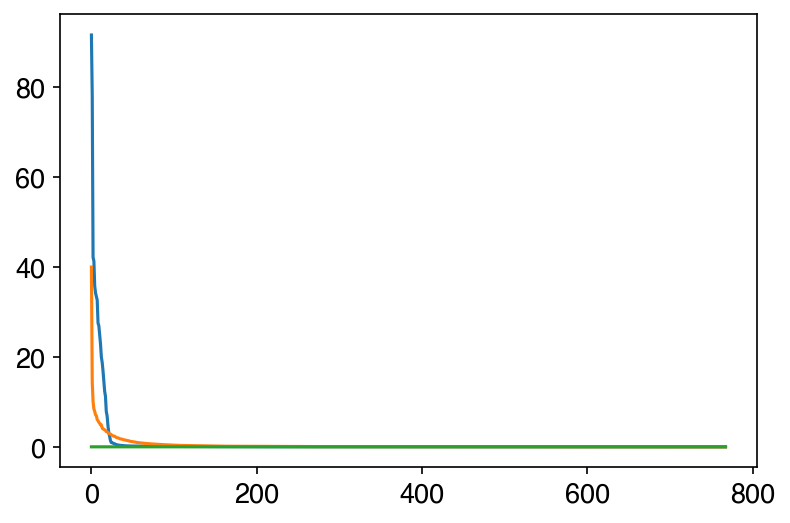

In [169]:
plt.plot(pca_ft.explained_variance_)
plt.plot(pca_untrained.explained_variance_)
plt.plot(pca_rand.explained_variance_)

/var/folders/r8/jdw1p2tj6jn34wf676kcsw_r0000gn/T/ipykernel_45003/2943005732.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


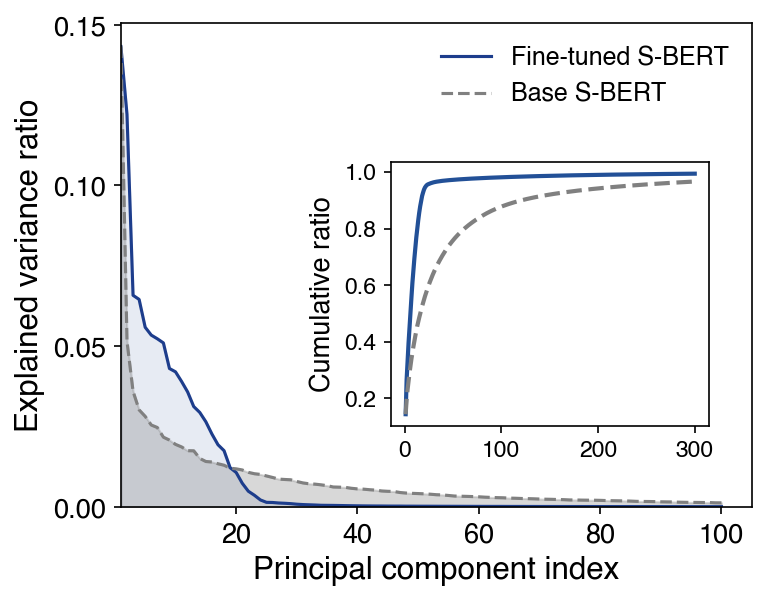

In [174]:
fig, ax1 = plt.subplots(figsize=(5.3,4.2))

N = 100
x = range(1, N+1)

#finetuned
plt.plot(x, exp_var_pca_ft[:N],color='#1D3D8C', label='Fine-tuned S-BERT')
plt.fill_between(x, exp_var_pca_ft[:N],  color='#1D3D8C', alpha=0.1)

#base
plt.plot(x, exp_var_pca_untrained[:N], ls='--', color='gray', label='Base S-BERT' )
plt.fill_between(x, exp_var_pca_untrained[:N],  color='gray', alpha=0.3)


#random
#plt.plot(x, exp_var_pca_rand[:N], color='#80A7F6', label='Fine-tuned S-BERT with shuffled triplets', zorder=0)
#plt.fill_between(x, exp_var_pca_rand[:N],  color='#80A7F6', alpha=0.3)
#plt.plot([],[], color='#80A7F6', label='Fine-tuned S-BERT with shuffled triplets')


plt.ylim(0.0,)
plt.xlim(1.0,)

plt.xticks(fontsize=13)
plt.yticks(np.arange(0,0.16,0.05),fontsize=13)
plt.ylabel('Explained variance ratio', fontsize=15)
plt.xlabel('Principal component index', fontsize=15)
ax1.legend(loc='best', fontsize=12, frameon=False)


left, bottom, width, height = [0.51, 0.3, 0.4, 0.42]
ax2 = fig.add_axes([left, bottom, width, height])
#ax2.plot(range(0,(300)+1), [0] + list(cum_sum_eigenvalues_rand[:300]),  color='#A7C9DF', alpha=1, lw=2.)
ax2.plot(range(1,(300)+1),  list(cum_sum_eigenvalues_ft[:300]),  color='#225097', alpha=1, lw=2.)
ax2.plot(range(1,(300)+1),  list(cum_sum_eigenvalues_untrained[:300]),  color='gray', ls='--', lw=2)
ax2.set_ylabel('Cumulative ratio', fontsize=13)
ax2.tick_params(labelsize = 11)

plt.tight_layout()
plt.savefig('../fig/UserEmbedding_PCA_variance(roberta-base_ft)_vs_Untrained_vs_RandomTriplets.pdf',transparent=True, bbox_inches='tight')

In [ ]:
### fig, ax1 = plt.subplots()

N = 50

#Finetuned
plt.plot(range(1,(N)+1), exp_var_pca_ft[:N],  color='#225097', lw=2, label='Fine-tuned S-BERT')
plt.bar(range(1,(N)+1), exp_var_pca_ft[:N], color='#225097', alpha=.6, width=1, align='center')

#Random
plt.plot(range(1,(N)+1), exp_var_pca_rand[:N],  color='#A7C9DF', lw=2, label='Fine-tuned S-BERT with shuffled triplets')
plt.bar(range(1,(N)+1), exp_var_pca_rand[:N], color='#A7C9DF', alpha=.6, width=1, align='center')

#untrained
plt.plot(range(1,(N)+1), exp_var_pca_untrained[:N],  color='gray', lw=2, label='Base S-BERT')
plt.bar(range(1,(N)+1), exp_var_pca_untrained[:N], color='gray', alpha=0.6, width=1, align='center')


plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Explained variance ratio', fontsize=15)
plt.xlabel('Principal component index', fontsize=15)
ax1.legend(loc='best', fontsize=12, frameon=False)
#ax1.set_ylim(0, 0.20)


left, bottom, width, height = [0.55, 0.3, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.step(range(1,(200)+1), cum_sum_eigenvalues_ft[:200], where='mid', color='#225097', alpha=1, lw=2.5)
ax2.step(range(1,(200)+1), cum_sum_eigenvalues_untrained[:200], where='mid', color='gray', ls='--', alpha=0.6)
ax2.step(range(1,(200)+1), cum_sum_eigenvalues_rand[:200], where='mid', color='#A7C9DF', alpha=1, lw=2.5)
ax2.set_ylabel('Cumulative ratio', fontsize=13)
ax2.tick_params(labelsize = 11)

plt.tight_layout()
#plt.savefig('../fig/UserEmbedding_PCA_variance(roberta-base_ft)_vs_Untrained_vs_RandomTriplets.pdf',transparent=True, bbox_inches='tight')
plt.show()